# Comparing MLP and Convolutional Models

## Description

In this week's homework, we'll use PyTorch to compare the performance of multi-layer perceptrons (MLP's; the kind of model we've looked at so far) against _convolutional_ neural networks (CNN's). We'll talk about convolutions in class on Monday, but you can get started on the MLP part of the homework as soon as you're ready. For our comparison we'll go back to the CIFAR-10 dataset, since it's a bit less chaotic than CIFAR-100.

As with the last homework, I have some guidelines about what parts of the homework are necessary for different grades:

- The basic version, for a C, is to define and train an MLP and a CNN.
- On top of that, the B level work requires you to analyze your results a bit. I'll describe this in more detail later in the notebook after the code that sets up and trains the networks.
- For an A, you'll need to finish the activation map visualization in the last section of this notebook. More details on that later on.

The rest of the document is organized into sections which are labeled with the grade they correspond to.

## Data Setup

The first section of the notebook gets the dataset and sets up the transforms we need. The code in this section is complete, although you may need to change the dataset path or change the `transform` definition to match your version of torchvision.

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
torchvision.disable_beta_transforms_warning()
import torchvision.transforms.v2 as transforms

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineRenderer.figure_format = 'retina'

In [10]:
transform = transforms.Compose([
    transforms.ToImageTensor(),
    transforms.ConvertImageDtype(),
])

# If you already have the CIFAR10 data downloaded from the in-class notebook, you can change the path here
# to point to it so you avoid downloading a second copy.
cifar = torchvision.datasets.CIFAR10("../data/torch/cifar", download=True, transform=transform)
train_size = int(0.8 * len(cifar))
train_data, valid_data = torch.utils.data.random_split(cifar, [train_size, len(cifar) - train_size])

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



Files already downloaded and verified


In [11]:
# Constants

cifar_mean = (0.4914, 0.4822, 0.4465)
cifar_std = (0.2470, 0.2435, 0.2616)

normalize = transforms.Normalize(cifar_mean, cifar_std)

### Set device to GPU

In [12]:
if torch.backends.mps.is_available():
    device = torch.device('mps')
else: 
    device = 'cpu'

print("Device:", device)

Device: mps


## Models and Training (C)

First, define an MLP model for the CIFAR dataset. An MLP, also called a fully-connected network, consists of linear computations alternated with nonlinear activation functions, just like every network we've looked at in this class so far. This is very similar to what we did in clas on Wednesday and lab on Friday.

In [37]:
class MLP(nn.Module):

    def __init__(self, arch=[256, 128], activation=nn.ReLU):
        super().__init__()
        self.layers = []
        arch.insert(0, 3 * 32 * 32)
        arch.append(100)
        for i in range(len(arch) - 1):
            self.layers.append(nn.Linear(arch[i], arch[i+1]))
            if i < len(arch) - 2:
                self.layers.append(activation())
        self.model = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.model(x.reshape(-1, 3 * 32 * 32)).squeeze(dim=0)

In [34]:
class CNN(nn.Module):

    def __init__(self, activation=nn.ReLU):
        super().__init__()
        self.c1 = nn.Conv2d(3, 8, 3, padding=3)
        self.a1 = activation()
        self.c2 = nn.Conv2d(8, 16, 3, groups=2, padding=1, stride=2)
        self.a2 = activation()
        self.c3 = nn.Conv2d(16, 32, 3, stride=2)
        self.flatten = nn.Flatten()
        self.l1 =  nn.Linear(32*8*8, 10)

    def forward(self, x):
        h1 = self.c1(x)
        h2 = self.a1(h1)
        h3 = self.c2(h2)
        h4 = self.a2(h3)
        h5 = self.c3(h4)
        h6 = self.flatten(h5)
        h7 = self.l1(h6)
        return h7

Now let's define a training function for our MLP. As usual, you may want to add more arguments to the training function. For the latter parts of the notebook, it will be helpful if your training function returns both the model and a list of the training and validation accuracies for each epoch.

In [39]:
def train(model_class=MLP, arch= [256,128], lr=1e-3, epochs=10, batch_size=64, momentum=0.9, reg=1e-5, activation=nn.ReLU, use_augmentation=False, aug_params=None):
 
    data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=False) # why shuffle = false here?

    if use_augmentation:
        augments = transforms.Compose([
            transforms.RandomHorizontalFlip(aug_params['flip_prob']),
            transforms.RandomGrayscale(aug_params['grayscale_prob']),
            transforms.ColorJitter(
                brightness=(aug_params['bright_min'], aug_params['bright_max']),
                contrast=0,
                saturation=0,
                hue=0),
            transforms.RandomCrop(
                size=32,
                padding=aug_params['shift_size'],
                fill=cifar_mean)
        ])


    train_accs = []
    valid_accs = []

    if model_class == MLP:
        model = MLP(arch=arch, activation=activation).to(device)
    if model_class == CNN:
        print(device)
        model = CNN().to(device)
    loss = nn.CrossEntropyLoss()
    opt = optim.SGD(model.parameters(), momentum=momentum, lr=lr, weight_decay=reg)
    
    for i in range(epochs):
        model.train() # why do we need this?
        accs = []
        for batch_xs, batch_ys in data_loader:
            batch_xs = batch_xs.to(device)
            batch_ys = batch_ys.to(device)

            if use_augmentation:
                batch_xs = augments(batch_xs).to(device)

            preds = model(normalize(batch_xs))
            loss_val = loss(preds, batch_ys)
            accs.append((preds.argmax(dim=1) == batch_ys).float().mean())

            # Update
            opt.zero_grad()
            loss_val.backward()
            opt.step()
        
        # average training accuracy
        train_accs.append(torch.tensor(accs).mean().item())

        # start over for eval stage
        model.eval()
        accs = []
        for batch_xs, batch_ys in valid_loader:
            batch_xs = batch_xs.to(device)
            batch_ys = batch_ys.to(device)
            valid_preds = model(normalize(batch_xs))
            accs.append((valid_preds.argmax(dim=1) == batch_ys).float().mean())
        
        valid_accs.append(torch.tensor(accs).mean().item())
        
        
        print("Epoch:", i, "Training accuracy:",train_accs[-1], "Validation accuracy:", valid_accs[-1])
    return model, train_accs, valid_accs

In [40]:
%%time

aug_params = {
    'flip_prob': 0.5,
    'grayscale_prob': 0.1,
    'bright_min': 0.9,
    'bright_max': 1.1,
    'shift_size': 2
}

mlp_model, mlp_train_accs, mlp_valid_accs = train(model_class=MLP, 
                                                    arch= [256,128],
                                                    lr=1e-3, 
                                                    epochs=15, 
                                                    batch_size=64,
                                                    momentum=0.9,
                                                    reg=1e-5, 
                                                    activation=nn.ReLU, 
                                                    use_augmentation=True, 
                                                    aug_params=aug_params
                                                    )


Epoch: 0 Training accuracy: 0.26625001430511475 Validation accuracy: 0.3520103394985199
Epoch: 1 Training accuracy: 0.35772499442100525 Validation accuracy: 0.40993231534957886
Epoch: 2 Training accuracy: 0.39024999737739563 Validation accuracy: 0.4251592457294464


KeyboardInterrupt: 

In [36]:
%%time
cnn_model, cnn_train_accs, cnn_valid_accs = train(model_class=CNN, 
                                                    lr=1e-2, 
                                                    epochs=20, 
                                                    batch_size=64,
                                                    momentum=0.9,
                                                    reg=1e-5, 
                                                    activation=nn.ReLU, 
                                                    use_augmentation=True, 
                                                    aug_params=aug_params)

mps
Epoch: 0 Acc: 0.4666600227355957
Epoch: 1 Acc: 0.49970144033432007
Epoch: 2 Acc: 0.5590167045593262
Epoch: 3 Acc: 0.5819068551063538
Epoch: 4 Acc: 0.581210196018219
Epoch: 5 Acc: 0.5984275341033936
Epoch: 6 Acc: 0.6018112897872925
Epoch: 7 Acc: 0.6088773608207703
Epoch: 8 Acc: 0.6194267272949219
Epoch: 9 Acc: 0.6260947585105896
Epoch: 10 Acc: 0.6190286874771118
Epoch: 11 Acc: 0.6169387102127075
Epoch: 12 Acc: 0.6132563948631287
Epoch: 13 Acc: 0.5932523608207703
Epoch: 14 Acc: 0.6359474658966064
Epoch: 15 Acc: 0.618630588054657
Epoch: 16 Acc: 0.6390326619148254
Epoch: 17 Acc: 0.6274880766868591
Epoch: 18 Acc: 0.6351512670516968
Epoch: 19 Acc: 0.6333598494529724
CPU times: user 2min 32s, sys: 11.8 s, total: 2min 44s
Wall time: 3min 5s


### Vizualize and plot

RuntimeError: linear(): input and weight.T shapes cannot be multiplied (32x64 and 2048x10)

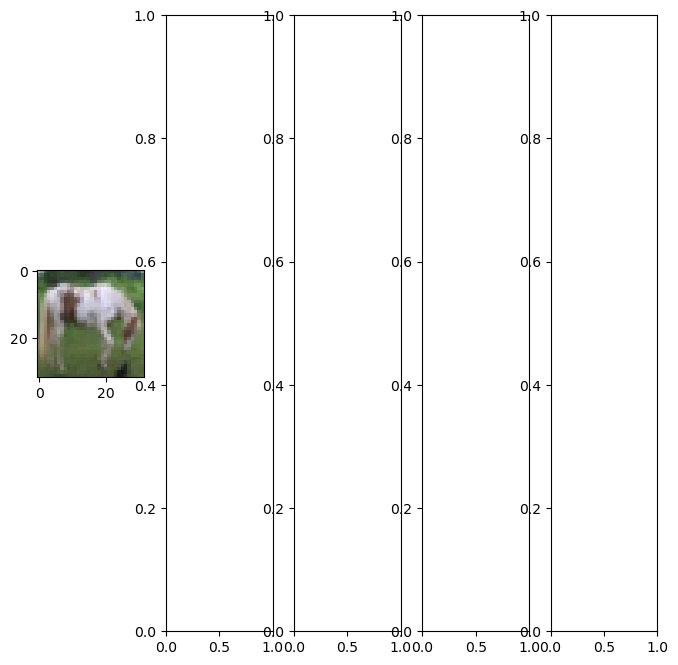

In [45]:
# # viz predictions

# fig, axs = plt.subplots(1, 5, figsize=(8, 8))
# for i in range(5):
#     r = torch.randint(len(cifar), (1,)).item()
#     axs[i].imshow(cifar[r][0].numpy().transpose(1, 2, 0))
#     preds = nn.functional.softmax(cnn_model(normalize(cifar[r][0]).to(device)), dim=0)

#     c = torch.argmax(preds)
#     axs[i].set_title("{}: ({:.2f})".format(classes[c], preds[c]))
# plt.show()

fig, axs = plt.subplots(1, 5, figsize=(8, 8))
for i in range(5):
    r = torch.randint(len(cifar), (1,)).item()
    cifar_gpu = cifar[r][0].to(device)

    preds = nn.functional.softmax(cnn_model(normalize(cifar_gpu)), dim=0)
    preds = preds.cpu()

    c = torch.argmax(preds)
    axs[i].imshow(cifar[r][0].numpy().transpose(1, 2, 0))
    axs[i].set_title("{}: ({:.2f})".format(classes[c], preds[c]))
plt.show()

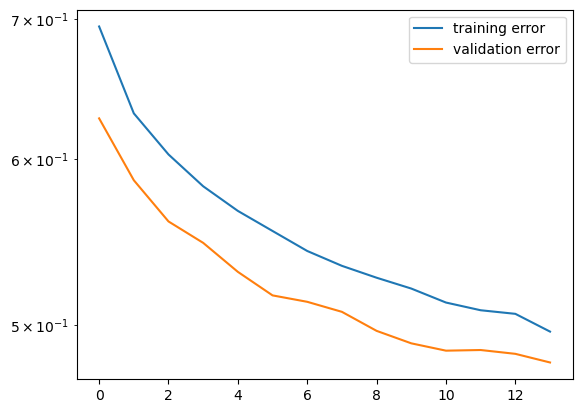

In [25]:
# Plot the training error against the validation error (something off)

smooth_train = np.convolve(mlp_train_accs, np.ones(2) / 2, mode='valid')
smooth_valid = np.convolve(mlp_valid_accs, np.ones(2) / 2, mode='valid')
plt.plot(range(len(smooth_train)), 1-smooth_train, label='training error')
plt.plot(range(len(smooth_valid)), 1-smooth_valid, label='validation error')
plt.yscale('log')
plt.legend()
plt.show()

Now you can define a CNN for the same task. NOTE: for the visualization at the end of the notebook you'll need to have access to the hidden layer outputs when running the network. If you plan to work on that part I would recommend setting up your CNN so that the `forward` function returns both the predictions and the values at the hidden layers. If you don't, there are some hacky ways to get around this later though.

Now you can train your CNN. You should be able use the same `train` function but pass it `model_class=CNN` (you may need to change some other hyperparameters to get good results).

Given how long it takes to train the CNN model, now might be a good time to talk about saving and loading models. The cell below will save your CNN model to the file `cnn_model.pt`.

In [ ]:
torch.save(cnn_model.state_dict(), "cnn_model.pt")

If you have the file `cnn_model.pt` on your system, then you can load it with this code:

In [ ]:
loaded_model = CNN()
loaded_model.load_stat_dict(torch.load("cnn_model.pt"))

In [ ]:
# find best parameters for CNN

## Analysis (B)

In this section, we'll do some minor analysis of the results of our experiment above. Let's compare

- the time taken to train each model,
- the validation accuracy over time,
- the total number of parameters in each model.

That last measurement, the total number of parameters, is something you'll need to compute pased on your network architecture. When I say number of parameters here, I'm referring to the total number of dimensions in the parameter space. That is, the total number of individual real numbers in our parameters. For example, a matrix of size 100x10 has 1,000 parameters.

I'm not asking for anything specific here, I'm just looking for you to think about the models we're using and their relative merits. If you think of something else that might be useful to compare the two networks, mention that as well.

In [ ]:
# You can use this cell for any code related to your analysis.

## Interpretation (A)

In this section, we'll explore our CNN and try to understand how it learns to recognize different objects. There are several approaches to this problem. For today we'll look at a simple one that only works for the first convolutional layer. If we plot the weights of the layer as image data, we can visualize the kinds of patterns the convolution is scanning for. In order to do this, you'll need to normalize each kernel to the range [0, 1], then transpose the axis to format the weights as image data, then use the `imshow` function from `matplotlib.pyplot`. The weights of a convolutional layer `conv` are stored as a tensor of shape `Cin, Cout, H, W` in `conv.weight`.

If you have a torch tensor `x` and you want to display it with `imshow` you'll need to convert it to numpy by calling `x.detach().numpy()`.

In [ ]:
# If your first convolutional layer has fewer than 16 output channels then you'll need to
# change the number of plots here.
fig, axs = plt.subplots(4, 4, figsize=(5, 5))
for i in range(4):
    for j in range(4):
        c = 4 * i + j
        YOUR_CODE_HERE
        axs[i,j].imshow(YOUR_CODE_HERE)
plt.show()